In [ ]:
!pip install pyopencl

import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!lscpu
!nvidia-smi

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

# Input

In [1]:
img = Image.open("/content/EJERCICIO1/input.png")
data_np = np.asarray(img)

fig, ax = plt.subplots()
ax.imshow(data_np,cmap='gray')
plt.axis('off')
plt.show()

NameError: ignored

# Kernels


In [ ]:
KernelSourceRot = """
__kernel void Rot(
  __global const int *data_g,
  __global int *res_g,
  const int c_x,
  const int c_y,
  const float sinTheta,
  const float cosTheta)
  {
    const int width = get_global_size(0);
    const int height = get_global_size(1);
    
    const int x = get_global_id(0);
    const int y = get_global_id(1);

    int x_f = (int)(cosTheta * (x-c_x) - sinTheta * (y-c_y) + c_x);
    int y_f = (int)(sinTheta * (x-c_x) + cosTheta * (y-c_y) + c_y);

    if ((x_f >= 0) && (y_f >= 0) && (x_f < width) && (y_f < height)) {
      res_g[(int)(y_f*width + x_f)] = data_g[y*width + x];
      // res_g[(int)(y_f*width + x_f)+1] = data_g[y*width + x];
    }
  }
"""

In [ ]:
KernelSourceEH = """
__kernel void EH(
  __global const int *data_g,
  __global int *res_g
)
{
  const int width = get_global_size(0);
  const int height = get_global_size(1);
    
  const int x = get_global_id(0);
  const int y = get_global_id(1);

  res_g[y*width + (width-x)] = data_g[y*width + x];
}
"""

In [ ]:
KernelSourceEV = """
__kernel void EV(
  __global const int *data_g,
  __global int *res_g
)
{
  const int width = get_global_size(0);
  const int height = get_global_size(1);
    
  const int x = get_global_id(0);
  const int y = get_global_id(1);

  res_g[(height-y)*width + x] = data_g[y*width + x];
}
"""

La descomposición que se decide usar guarda relación con qué es lo que van a representar los global id calculados.

## Descomposición de datos con respecto a la entrada
Con los global id, se indexa la entrada.


## Descomposición de datos con respecto a la salida
Con los global id, se indexa la salida.

Para este ejercicio, en los kernels se podría haber utilizado tanto descomposición de entrada como de salida. Esto es asi ya que un pixel de entrada se mapea con (a lo sumo) un pixel de salida y viceversa. Decidimos utilizar descomposición de entrada para los tres kernels ya que nos pareció más intuitivo.


# Inicialización del host


In [ ]:
# Obtener la plataforma
plataform_list = cl.get_platforms()

# Obtener los dispositivos
devices = plataform_list[0].get_devices(device_type = cl.device_type.GPU)

# Crear el contexto
context = cl.Context(devices=devices)

# Crear el Command Queue
queue = cl.CommandQueue(
    context,
    properties=cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE
)

# Crear e inicializar el vector (bidimensional) de entrada
img_np = np.asarray(img)
height = img_np.shape[0]
width = img_np.shape[1]

# Crear e inicializar el vector (bidimensional) de salida
res_np = np.empty_like(img_np)

# Crear e inicializar el buffer de entrada (OpenCL)
data_g = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = img_np)

# Create e inicializar el buffer de salida (OpenCL)
# NOTA: inicialmente tiene los mismos contenidos que el buffer de entrada
res_g = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = res_np)

# Definir espacio indexado
globalRange = (width, height)
localRange = None

# Output

Imagen original


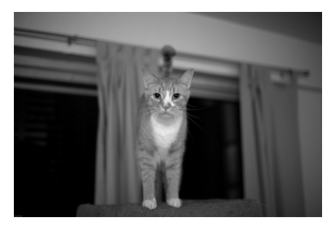



Espejado vertical


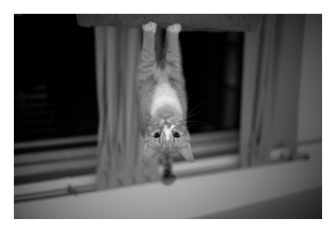



Espejado horizontal


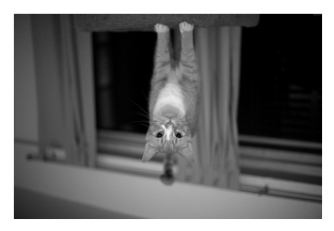



Rotación de 56.3 grados, con centro de rotación (150, 150)


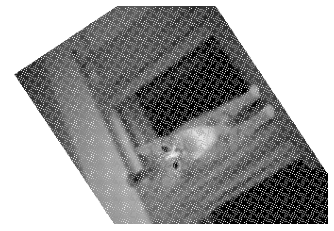



Rotación de 90.0 grados, con centro de rotación (150, 150)


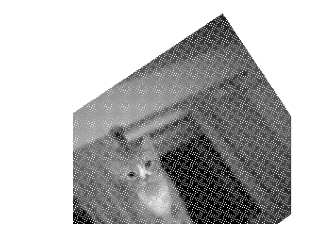

In [ ]:
P = ['EV','EH',['ROT', 150, 150, 56.3], ['ROT', 150, 150, 90.0]]

print('Imagen original')
fig, ax = plt.subplots()
ax.imshow(img_np,cmap='gray')
plt.axis('off')
plt.show()
print('\n')

for action in P:
  # Rotación
  if isinstance(action, list):
    print(f'Rotación de {action[3]} grados, con centro de rotación ({action[1]}, {action[2]})')
    program = cl.Program(context, KernelSourceRot).build()
    kernel = program.Rot
    kernel.set_scalar_arg_dtypes([None, None, np.int32, np.int32, np.float32, np.float32])
    
    c_x = action[1]
    c_y = action[2]
    sinTheta = np.sin(np.radians(action[3]))
    cosTheta = np.cos(np.radians(action[3]))

    kernel.set_args(data_g, res_g, c_x, c_y, sinTheta, cosTheta)
  
  # Espejado vertical
  elif action == 'EV':
    print('Espejado vertical')
    program = cl.Program(context, KernelSourceEV).build()
    kernel = program.EV
    
    kernel.set_args(data_g, res_g)

  # Espejado horizontal
  elif action == 'EH':
    print('Espejado horizontal')
    program = cl.Program(context, KernelSourceEH).build()
    kernel = program.EH
    
    kernel.set_args(data_g, res_g)
  
  # Ejecutar kernel
  ev = cl.enqueue_nd_range_kernel(queue, kernel, globalRange, localRange)
  ev.wait()
  
  # Copiar el resultado del device (res_g) al host (res_np)
  copy_ev = cl.enqueue_copy(queue, res_np, res_g)
  copy_ev.wait()

  # Mostrar resultado de la iteración
  fig, ax = plt.subplots()
  ax.imshow(res_np,cmap='gray')
  plt.axis('off')
  plt.show()
  print('\n')

  # El siguiente data_g tiene que ser el resultado de esta iteración
  data_g = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = res_np)
  
  # Limpiamos el res_g
  empty_ev = cl.enqueue_fill_buffer(queue, res_g, np.uint32(0), 0, height*width*4)
  empty_ev.wait()

# Inicializar buffers con contenido original para la próxima ejecución de este bloque
data_g = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf = img_np)

Al utilizar una command queue out of order (por un requisito del enunciado) y al ser necesario sincronismo entre la ejecución de los distintos eventos (ejecutar el kernel y copiar el resultado del device al host), debemos utilizar sentencias wait para esperar que uno termine antes que comience el otro.